# Previsão de Diabetes

### 1. Importação das Bibliotecas

In [1]:
# Manipulação e Geração de Dados
import pandas as pd
import numpy as np
import random

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, classification_report

import joblib

### 2. Geração de Dados Sintéticos

In [2]:
n_samples = 10000

# Gêneros possíveis
genders = ['Masculino', 'Feminino']

# Classes alvo possíveis
targets = ['Diabetes Tipo 1', 'Diabetes Tipo 2', 'Pré-diabetes', 'Não diabético']

# Função para gerar amostra com ruídos naturais e sem restrição por classe
def gerar_amostra_realista():
    idade = np.random.randint(10, 90)
    genero = random.choice(genders)

    imc = round(np.random.normal(loc=25, scale=6), 1)
    glicemia = np.random.randint(60, 300)
    hba1c = round(np.random.normal(loc=6.0, scale=1.2), 1)
    insulina = round(np.random.uniform(2, 30), 1)
    atividade = np.random.randint(0, 10)
    historico = np.random.choice([0, 1], p=[0.7, 0.3])
    pressao = np.random.randint(90, 180)
    colesterol = np.random.randint(120, 280)
    triglicerideos = np.random.randint(50, 300)

    # Adicionando variabilidade na rotulagem
    if glicemia > 250 or hba1c > 10:
        classe = 'Diabetes Tipo 1'
    elif hba1c >= 6.5 and glicemia > 125:
        classe = 'Diabetes Tipo 2'
    elif 100 <= glicemia <= 125 or (5.7 <= hba1c < 6.5):
        classe = 'Pré-diabetes'
    else:
        classe = 'Não diabético'

    # Introduzir um ruído de rotulagem para simular erros de diagnóstico
    if np.random.rand() < 0.1:
        classe = random.choice(targets)

    return [
        idade, genero, imc, glicemia, hba1c, insulina, atividade,
        historico, pressao, colesterol, triglicerideos, classe
    ]

# Gerar base de dados
dados = [gerar_amostra_realista() for _ in range(n_samples)]

# Nome das colunas
colunas = [
    'idade', 'genero', 'imc', 'glicemia', 'hba1c', 'insulina',
    'atividade_fisica', 'historico_familiar', 'pressao_arterial',
    'colesterol_total', 'triglicerideos', 'diagnostico'
]

df = pd.DataFrame(dados, columns=colunas)

# Exportar CSV
caminho_csv = "dataset_clinico_realista.csv"
df.to_csv(caminho_csv, index=False)

caminho_csv


'dataset_clinico_realista.csv'

### 3. Análise de Dados

#### 3.1 Configuração para os gráficos

In [3]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (8, 6)

#### 3.2 Importação dos Dados

In [4]:
dataframe = pd.read_csv("dataset_clinico_realista.csv")
dataframe                                                       

,idade,genero,imc,glicemia,hba1c,insulina,atividade_fisica,historico_familiar,pressao_arterial,colesterol_total,triglicerideos,diagnostico
0,54,Masculino,18.9,219,5.7,12.0,9,0,123,150,124,Pré-diabetes
1,21,Masculino,27.8,119,4.6,12.9,5,1,179,152,283,Pré-diabetes
2,83,Masculino,18.9,263,7.2,10.2,3,0,138,141,223,Diabetes Tipo 1
3,22,Feminino,33.2,268,7.2,22.3,0,1,132,180,158,Diabetes Tipo 1
4,81,Masculino,29.1,155,6.8,25.2,5,1,135,141,222,Diabetes Tipo 2
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,45,Feminino,27.7,210,7.1,16.6,9,1,172,161,157,Diabetes Tipo 2
9996,31,Masculino,30.9,128,6.9,27.2,0,1,127,268,83,Diabetes Tipo 2
9997,53,Masculino,16.7,89,6.0,18.5,0,0,98,149,141,Pré-diabetes
9998,62,Feminino,25.4,179,6.0,10.5,4,0,162,124,263,Pré-diabetes


#### 3.3 Informação dos Dados

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idade               10000 non-null  int64  
 1   genero              10000 non-null  object 
 2   imc                 10000 non-null  float64
 3   glicemia            10000 non-null  int64  
 4   hba1c               10000 non-null  float64
 5   insulina            10000 non-null  float64
 6   atividade_fisica    10000 non-null  int64  
 7   historico_familiar  10000 non-null  int64  
 8   pressao_arterial    10000 non-null  int64  
 9   colesterol_total    10000 non-null  int64  
 10  triglicerideos      10000 non-null  int64  
 11  diagnostico         10000 non-null  object 
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


#### 3.4 Observando as Distribuições em cada Atributo

3.4.1 Idade

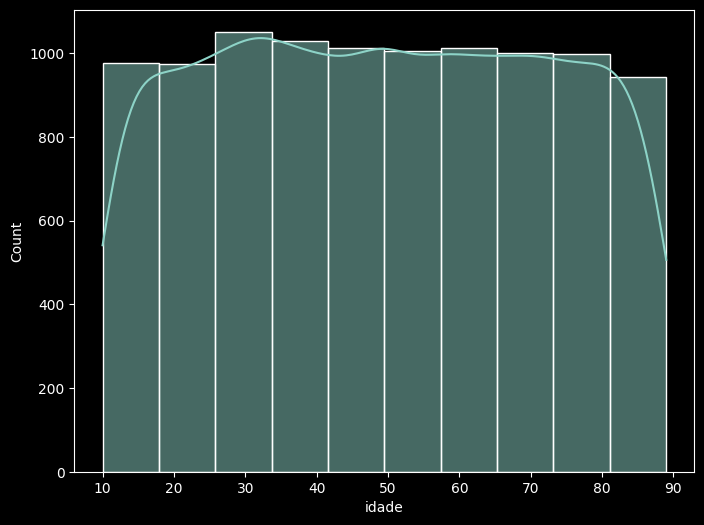

In [6]:
sns.histplot(dataframe['idade'], bins=10, kde=True)  # `dados` é sua série numérica
plt.show()

3.4.2 IMC

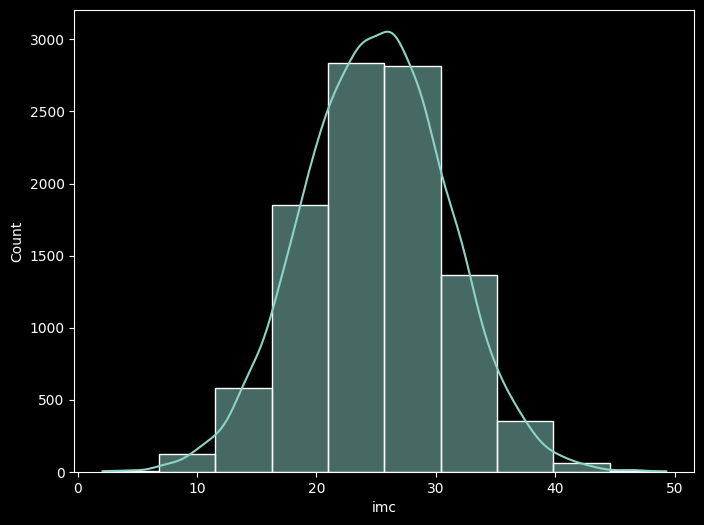

In [7]:
sns.histplot(dataframe['imc'], bins=10, kde=True)  # `dados` é sua série numérica
plt.show()

3.4.3 Glicemia

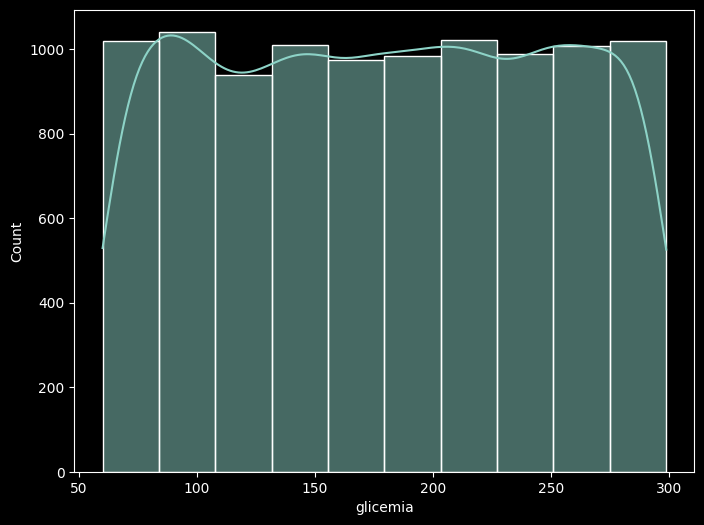

In [8]:
sns.histplot(dataframe['glicemia'], bins=10, kde=True)  # `dados` é sua série numérica
plt.show()

3.4.4 HBA1C

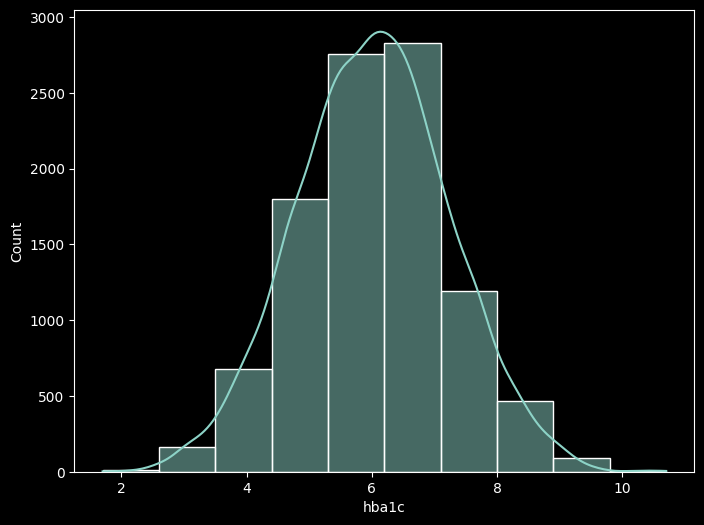

In [9]:
sns.histplot(dataframe['hba1c'], bins=10, kde=True)  # `dados` é sua série numérica
plt.show()

3.4.5 Insulina

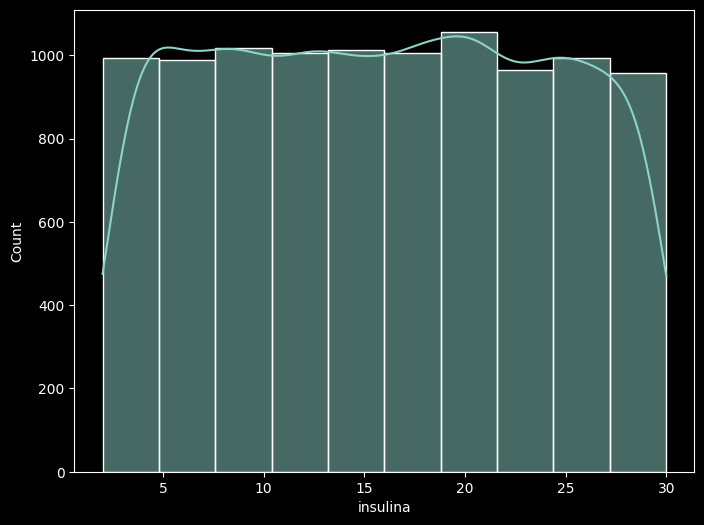

In [10]:
sns.histplot(dataframe['insulina'], bins=10, kde=True)  # `dados` é sua série numérica
plt.show()

3.4.6 Atividade Física

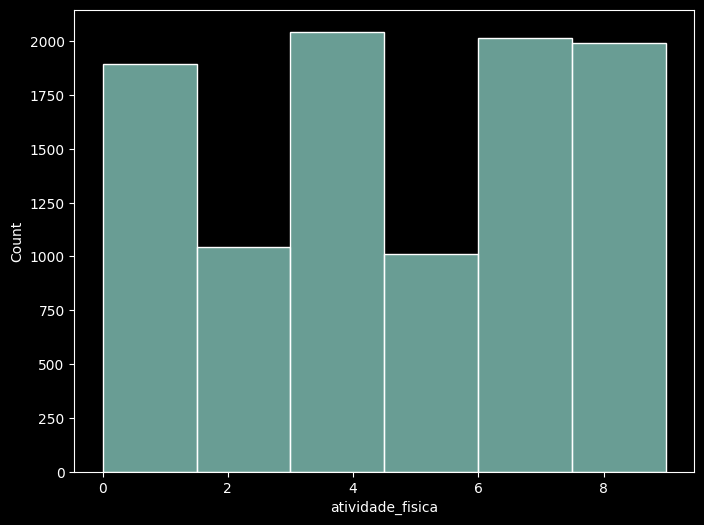

In [11]:
sns.histplot(dataframe['atividade_fisica'], bins=6)  # `dados` é sua série numérica
plt.show()

3.4.7 Historico Familiar

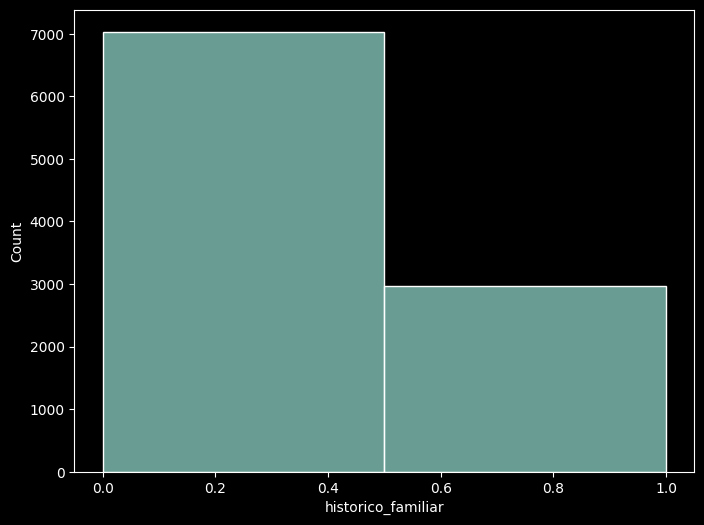

In [12]:
sns.histplot(dataframe['historico_familiar'], bins=2)  # `dados` é sua série numérica
plt.show()

3.4.8 Pressao Arterial

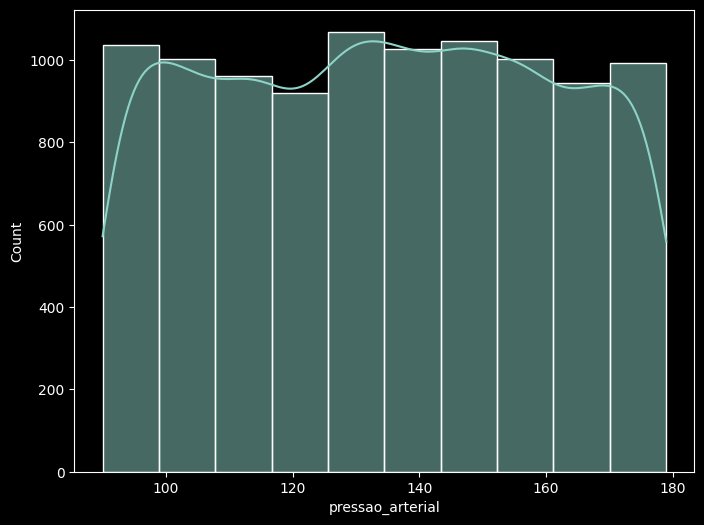

In [13]:
sns.histplot(dataframe['pressao_arterial'], bins=10,kde=True)  # `dados` é sua série numérica
plt.show()

3.4.9 Gênero

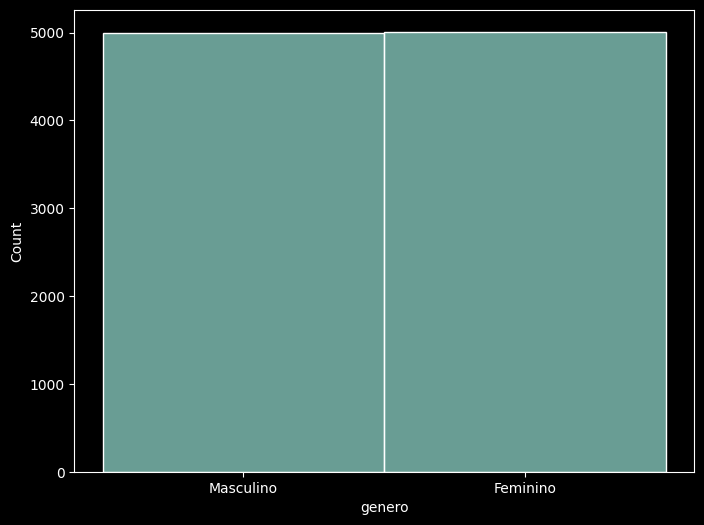

In [14]:
sns.histplot(dataframe['genero'], bins=2)  # `dados` é sua série numérica
plt.show()

3.4.10 Colesterol Total

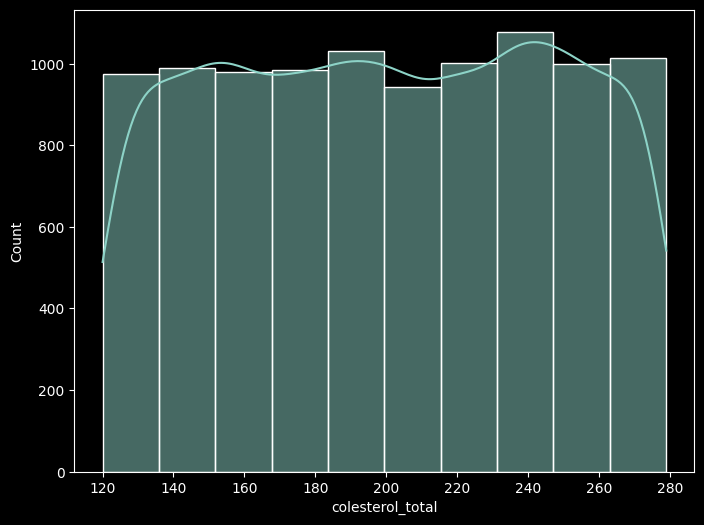

In [15]:
sns.histplot(dataframe['colesterol_total'], bins=10,kde=True)  # `dados` é sua série numérica
plt.show()


3.4.10 Triglicerideos

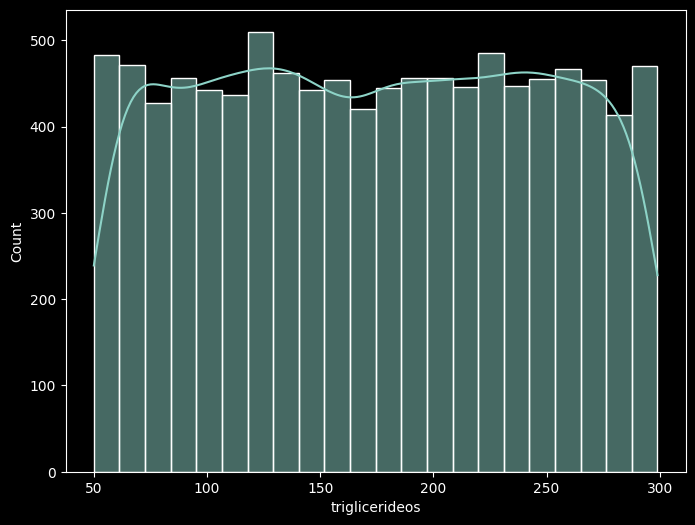

In [16]:
sns.histplot(dataframe['triglicerideos'] ,kde=True)  # `dados` é sua série numérica
plt.show()

### 4 Pré-processamento dos Dados

In [17]:
x_data = dataframe.iloc[:, 0:11].values
y_data = dataframe.iloc[:, 11].values

x_data, y_data

(array([[54, 'Masculino', 18.9, ..., 123, 150, 124],
        [21, 'Masculino', 27.8, ..., 179, 152, 283],
        [83, 'Masculino', 18.9, ..., 138, 141, 223],
        ...,
        [53, 'Masculino', 16.7, ..., 98, 149, 141],
        [62, 'Feminino', 25.4, ..., 162, 124, 263],
        [18, 'Feminino', 17.6, ..., 170, 186, 54]],
       shape=(10000, 11), dtype=object),
 array(['Pré-diabetes', 'Pré-diabetes', 'Diabetes Tipo 1', ...,
        'Pré-diabetes', 'Pré-diabetes', 'Diabetes Tipo 1'],
       shape=(10000,), dtype=object))

In [18]:
colunas_numericas = [
   0, 2, 3, 4, 5, 6, 7, 8, 9, 10
]

In [19]:
encoder_cat = LabelEncoder()
x_data[:, 1] = encoder_cat.fit_transform(x_data[:, 1])  # Codificando a coluna 'genero': 1 para masculino, 0 para feminino

In [10]:
pipeline_numerico = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),    # Tratando valores ausentes com a média
    ("minmax", MinMaxScaler()),                     # Normalizando os dados
    ("standard", StandardScaler())                  # Padronizando os dados
])

In [11]:
transformer = ColumnTransformer(
    transformers=[
        ("num", pipeline_numerico, colunas_numericas)
    ],
    remainder="passthrough"
)

In [12]:
x_data = transformer.fit_transform(x_data)
x_data

array([[0.3737121163840041, -0.9431389660208513, -0.9297626038646534,
        ..., 0.5041344136990584, -0.23456928568020724, 1],
       [0.5905982252030979, 0.4180035453964777, -0.4371700745555779, ...,
        -0.4892594208032924, -0.8575107105190554, 0],
       [1.3280109951880168, -0.3621635038305278, -1.2484989463587612,
        ..., -0.7268101203582021, 0.1253524264489054, 1],
       ...,
       [-0.4070778753647335, 0.4180035453964777, -0.8138584793213415,
        ..., -0.5972370115100696, -0.4283732845189598, 0],
       [0.9376159993136479, -0.6111529876263808, 1.3158798091620154, ...,
        -1.072338410619889, -0.649863568906106, 1],
       [-0.3203234318370963, 0.03621967024283701, 0.6204550619021434,
        ..., -0.6836190840754912, 1.4958235610943715, 0]],
      shape=(10000, 11), dtype=object)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.35, random_state=42)

In [14]:
model_random = RandomForestClassifier(random_state=42)
model_random.fit(x_train, y_train)
y_pred = model_random.predict(x_test)

In [15]:
print(classification_report(y_test, y_pred))


                 precision    recall  f1-score   support

Diabetes Tipo 1       0.94      0.90      0.92       685
Diabetes Tipo 2       0.93      0.90      0.92       698
  Não diabético       0.92      0.95      0.93      1137
   Pré-diabetes       0.91      0.93      0.92       980

       accuracy                           0.93      3500
      macro avg       0.93      0.92      0.92      3500
   weighted avg       0.93      0.93      0.93      3500



In [16]:
confusion_matrix(y_test, y_pred)

array([[ 619,   12,   25,   29],
       [  12,  630,   32,   24],
       [  16,   14, 1075,   32],
       [  10,   18,   38,  914]])

In [17]:
model_logistic = LogisticRegression(random_state=42)
model_logistic.fit(x_train, y_train)
y_pred = model_logistic.predict(x_test)

In [18]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

Diabetes Tipo 1       0.73      0.86      0.79       685
Diabetes Tipo 2       0.78      0.66      0.72       698
  Não diabético       0.65      0.75      0.70      1137
   Pré-diabetes       0.56      0.46      0.51       980

       accuracy                           0.67      3500
      macro avg       0.68      0.68      0.68      3500
   weighted avg       0.67      0.67      0.67      3500



In [19]:
confusion_matrix(y_test, y_pred)

array([[590,  37,  42,  16],
       [ 59, 462,  29, 148],
       [ 69,  32, 848, 188],
       [ 87,  62, 380, 451]])

### 5. Importação do Modelo e do Pré-processamento

In [21]:
joblib.dump(model_random, 'modelo_random_forest.pkl')
joblib.dump(transformer, 'transformer.pkl')

['transformer.pkl']